## Classifying Medical Text with PyTorch

This project explores building deep learning models in PyTorch to classify health‑related medical text into the correct focus area.
We use a subset of the [MedQuAD dataset](https://github.com/abachaa/MedQuAD/tree/master) from this [research paper](https://arxiv.org/pdf/1901.08079), containing real‑world question‑answer pairs from trusted health sources such as the NIH and MedlinePlus. Each answer is linked to a focus area that defines its broader medical topic.

**Motivation**:
Manual labeling of medical information in clinical settings is tedious, time‑consuming, and costly. Our aim is to develop an automated AI system to help medical professionals categorize and organize large volumes of medical information quickly and accurately.

**Models**
- Feedforward Neural Network
- Baseline model.
- Fast to train, low computational cost.
- Fine‑tuned PubMedBERT
- Pre‑trained on biomedical literature.
- Uses attention mechanisms for deeper language understanding in the medical domain.

**Dataset**: MedQuAD Subset – Column Summary
- **question**: Patient‑style medical question.
- **answer**: Verified response from a trusted health organization.
- **source**: Official origin of the QA pair.
- **focus_area**: Broad medical topic category.

`Disclaimer`:
Models are trained on a limited dataset and may not generalize to broader populations or clinical use. They are not intended for medical diagnosis, prediction, or management of health outcomes. All medical decisions should be made with a qualified healthcare professional.






In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing required Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import logging
logging.set_verbosity_error()
import seaborn as sns
sns.set(style="whitegrid", palette='Paired')
%matplotlib inline

In [6]:
medquad_df = pd.read_csv('drive/MyDrive/PyTorch_Capstone/datasets/medquad.csv')
medquad_df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [7]:
medquad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


We observe from the information that there are 16,412 question-answer pairs in the dataset. But there are 5 answers missing or null and 14 missing or null focus area.

## **Data Exploration and Visualization**

We will now explore and visualize the data in our dataset.

**Focus Area**

In [8]:
# Count the number of unique focus areas
medquad_df['focus_area'].nunique()

5126

In [9]:
# Counts of the top 20 most common focus areas
medquad_df['focus_area'].value_counts().head(25)

,count
focus_area,
Breast Cancer,53
Prostate Cancer,43
Stroke,35
Skin Cancer,34
Alzheimer's Disease,30
Colorectal Cancer,29
Lung Cancer,29
Causes of Diabetes,28
Heart Failure,28


**Focus Groups**

Instead of trying to classify 5,126 unique classes, we will group the top 20 most common focus areas into  broader categories (focus groups).

* Cancers
* Cardiovascular diseases
* Metabolic and endocrine disorders
* Neurological and cognitive disorders
* Other age-related and immune disorders

In [10]:
# Group the top 25 most common focus areas into 5 broader categories (focus groups)
focus_area_map = {
    'Cancers': ['Breast Cancer', 'Prostate Cancer', 'Skin Cancer', 'Colorectal Cancer', 'Lung Cancer', 'Leukemia'],
    'Cardiovascular Diseases': ['Stroke', 'Heart Failure', 'Heart Attack', 'High Blood Cholesterol', 'High Blood Pressure'],
    'Metabolic & Endocrine Disorders': ['Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy', 'Hemochromatosis', 'Kidney Disease'],
    'Neurological & Cognitive Disorders': ['Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems'],
    'Other Age-Related & Immune Disorders': ['Shingles', 'Osteoporosis', 'Age-related Macular Degeneration', 'Psoriasis', 'Gum (Peridontal) Disease', 'Dry Mouth']
}

# Create reverse mapping
condition_to_focus_area = {
    condition: focus_area
    for focus_area, conditions in focus_area_map.items()
    for condition in conditions
}

# Create new column 'focus_group' containing focus group
medquad_df['focus_group'] = medquad_df['focus_area'].map(condition_to_focus_area)

# Verify the number of unique focus groups
n_focus_groups = medquad_df['focus_group'].nunique()
print("Number of unique focus groups:", n_focus_groups)


Number of unique focus groups: 5


When we created the new column `focus_group`, it returned `nan` values for rows without a focus group (corresponding to rows whose focus area was not in the top 25 most occuring).

We'll use `.dropna()` to drop the rows with `nan` values.

In [11]:
# Dropping missing values including those without a focus group
print("Shape before dropping:", medquad_df.shape)
medquad_df = medquad_df.dropna()
print("Shape after dropping: ", medquad_df.shape)

Shape before dropping: (16412, 5)
Shape after dropping:  (628, 5)


Let's visualize the counts within each focus group.

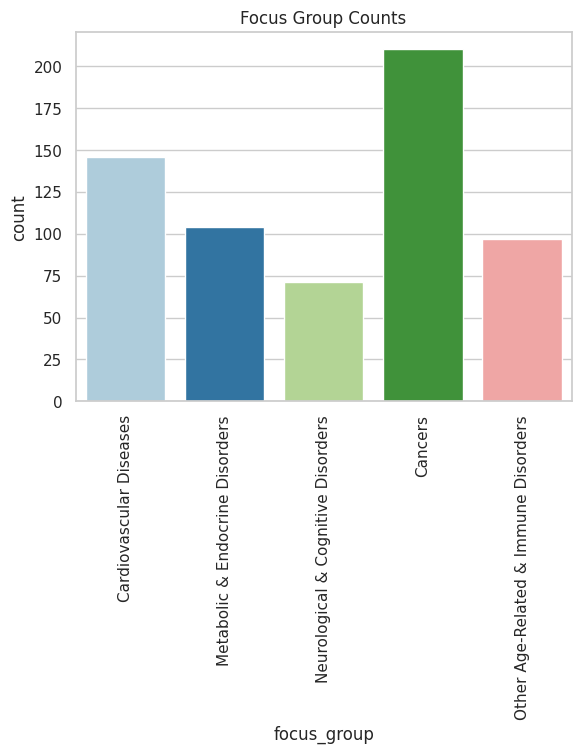

focus_group
Cancers                                 210
Cardiovascular Diseases                 146
Metabolic & Endocrine Disorders         104
Other Age-Related & Immune Disorders     97
Neurological & Cognitive Disorders       71
Name: count, dtype: int64
focus_group
Cancers                                 0.334395
Cardiovascular Diseases                 0.232484
Metabolic & Endocrine Disorders         0.165605
Other Age-Related & Immune Disorders    0.154459
Neurological & Cognitive Disorders      0.113057
Name: proportion, dtype: float64


In [12]:
# Plot focus group counts
sns.countplot(x='focus_group', data=medquad_df, hue='focus_group')
plt.title('Focus Group Counts')
plt.xticks(rotation=90)
plt.show()

print(medquad_df['focus_group'].value_counts(0))
print(medquad_df['focus_group'].value_counts(1))

**Answer Training Text**

Now we will calculate the descriptive statistics for the text lengths in the `answer` column, which will serve as the training texts.

In [13]:
# Character lengths
medquad_df['answer_char_length'] = medquad_df['answer'].astype(str).apply(len)
# Word lengths
medquad_df['answer_word_count'] = medquad_df['answer'].astype(str).apply(lambda x: len(x.split()))

# Calculate descriptive statistics
answer_length_stats = medquad_df[['answer_char_length', 'answer_word_count']].describe()
answer_length_stats

,answer_char_length,answer_word_count
count,628.000000,628.000000
mean,2108.474522,334.011146
std,2762.223394,421.875154
min,88.000000,10.000000
25%,464.500000,75.000000
50%,1081.000000,173.000000
75%,2665.000000,431.000000
max,29046.000000,4281.000000


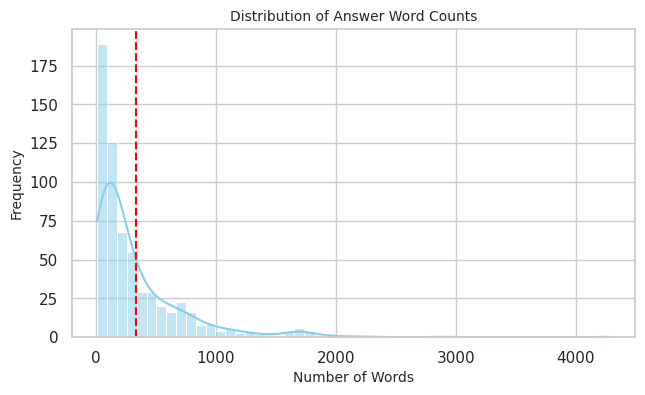

In [15]:
# Visualize the distribution of word counts
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.histplot(medquad_df['answer_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Answer Word Counts', fontsize=10)
plt.xlabel('Number of Words', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.axvline(x=answer_length_stats['answer_word_count']['mean'], color='red', linestyle='--', label=f"Mean: {answer_length_stats['answer_word_count']['mean']:.2f}")
plt.show()

Observing the stats for the word counts in the `answer` text, we see that:
* the mean word count is 334 words.
* the median word count is 171 words.
* the shortest text is 10 words
* the longest text is 4281 words.

We can consider dropping texts with notably low or high word counts (outliers).

## **Text Cleaning and Preprocessing**

Now, we will clean and pre-process the texts in the `answer` column and the target labels in the `focus-group` column.

**Encode Target Focus Groups**

In [16]:
focus_map = {'Neurological & Cognitive Disorders': 0, 'Cancers': 1, 'Cardiovascular Diseases': 2, 'Metabolic & Endocrine Disorders': 3, 'Other Age-Related & Immune Disorders': 4}
medquad_df['focus_group'] = medquad_df['focus_group'].replace(focus_map)

/tmp/ipython-input-4252006426.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  medquad_df['focus_group'] = medquad_df['focus_group'].replace(focus_map)


**Drop Duplicated Rows**

We observed that many of the text in the `answer` column are duplicates (or fairly similar), which is common among medical texts.

we'll need to drop duplicates, otherwise:
* the model will overfit to over-represented texts
* the model will have trouble generalizng to new, unseen texts
* model training will take longer than necessary

In [17]:
# Return all rows that are duplicates of a previous row
print("Shape before duplicates:", medquad_df.shape)
duplicates = medquad_df[medquad_df.duplicated(subset='answer')]
medquad_df = medquad_df.drop_duplicates(subset='answer')
print("Shaoe after removing duplicates:", medquad_df.shape)

Shape before duplicates: (628, 7)
Shaoe after removing duplicates: (605, 7)


**Split the dataset into training and testing sets**

We now split the dataset into training and testing sets. We use 80% of the data for training and 20% for testing.

Since our dataset is quite small, we'll need to stratify the distribution of focus groups to ensure fair representation in both training and testing sets.

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(medquad_df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=medquad_df['focus_group'])

In [19]:
print('Training set distribution:', train_df['focus_group'].value_counts(1))
print('Testing set distribution:',test_df['focus_group'].value_counts(1))

Training set distribution: focus_group
1    0.345041
2    0.241736
4    0.161157
3    0.134298
0    0.117769
Name: proportion, dtype: float64
Testing set distribution: focus_group
1    0.347107
2    0.239669
4    0.157025
3    0.140496
0    0.115702
Name: proportion, dtype: float64


**Create Training Corpus**

Next, we will create a training corpus by converting each text sequence and focus group labels to lists:

* `train_texts` will contain each answer text separated by commas
* `train_labels` will contain each focus group label separated by commas

In [20]:
train_texts = train_df['answer'].tolist()
train_labels = train_df['focus_group'].tolist()

# Print the first two training texts and labels
print(train_texts[:2])
print(train_labels[:2])

["Your doctor will diagnose hemochromatosis based on your medical and family histories, a physical exam, and the results from tests and procedures.\n                \nThe disease sometimes is detected while checking for other diseases or conditions, such as arthritis, liver disease, diabetes, heart disease, or erectile dysfunction (impotence).\n                \nSpecialists Involved\n                \nFamily doctors and internal medicine specialists may diagnose and treat hemochromatosis. Other doctors also may be involved in diagnosing and treating the disease, including:\n                \nHematologists (blood disease specialists)\n                \nCardiologists (heart specialists)\n                \nEndocrinologists (gland system specialists)\n                \nHepatologists (liver specialists)\n                \nGastroenterologists (digestive tract specialists)\n                \nRheumatologists (specialists in diseases of the joints and tissues)\n                \nMedical and Fam

**Removing Keywords from Training Text**

One issue we might encounter is that the training text might contain the actual focus group label, which may cause data leakage. Our model could cheat by detecting keywords and memorizing the focus group label instead of actually learning the patterns and relatiosnhips within the medical text.

One strategy is to remove keywords from the training text:

In [21]:
import re

remove_keywords = ['Breast Cancer', 'Prostate Cancer', 'Skin Cancer',
    'Colorectal Cancer', 'Lung Cancer', 'Leukemia', 'Stroke', 'Heart Failure', 'Heart Attack',
    'High Blood Cholesterol', 'High Blood Pressure', 'Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
    'Hemochromatosis', 'Kidney Disease', 'Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems',
    'Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
    'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth']

# Split all multi-word phrases into individual words
# Ex. "High Blood Cholesterol" ==> "High", "Blood", "Cholesterol"
words_to_remove = set()
for keyword in remove_keywords:
    for word in re.findall(r'\b\w+\b', keyword):
        words_to_remove.add(word.lower()) # lowercased for case-insensitive match

# Create regex pattern to match any of the words
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b', flags=re.IGNORECASE)

# Remove individual words from each text
masked_train_texts = [pattern.sub('', text) for text in train_texts]

# Normalize whitespace
masked_train_texts = [re.sub(r'\s+', ' ', text).strip() for text in masked_train_texts]

**Tokenize the Training Text**

Next we'll tokenize each training text into word tokens

In [22]:
import re
def tokenize(text):
    tokenized_text = re.findall(r'\b\w+\b', text.lower())
    return tokenized_text

tokenized_train_texts = [tokenize(focus_area_text) for focus_area_text in masked_train_texts]

# Print the first tokenized text sequence
print(tokenized_train_texts[0])

['your', 'doctor', 'will', 'diagnose', 'based', 'on', 'your', 'medical', 'and', 'family', 'histories', 'a', 'physical', 'exam', 'and', 'the', 'results', 'from', 'tests', 'and', 'procedures', 'the', 'sometimes', 'is', 'detected', 'while', 'checking', 'for', 'other', 'diseases', 'or', 'conditions', 'such', 'as', 'arthritis', 'liver', 'or', 'erectile', 'dysfunction', 'impotence', 'specialists', 'involved', 'family', 'doctors', 'and', 'internal', 'medicine', 'specialists', 'may', 'diagnose', 'and', 'treat', 'other', 'doctors', 'also', 'may', 'be', 'involved', 'in', 'diagnosing', 'and', 'treating', 'the', 'including', 'hematologists', 'specialists', 'cardiologists', 'specialists', 'endocrinologists', 'gland', 'system', 'specialists', 'hepatologists', 'liver', 'specialists', 'gastroenterologists', 'digestive', 'tract', 'specialists', 'rheumatologists', 'specialists', 'in', 'diseases', 'the', 'joints', 'and', 'tissues', 'medical', 'and', 'family', 'histories', 'to', 'learn', 'about', 'your', 

**Count the Number of Occurances for each Word Token**

In [23]:
from collections import Counter
combined_training_corpus = []
for text in tokenized_train_texts:
    for token in text:
        combined_training_corpus.append(token)

word_freqs = Counter(combined_training_corpus)


**Create the Vocabulary**

We'll build the vocabulary using the top 1,000 most commonly occuring word tokens.

In [24]:
MAX_VOCAB_SIZE = 1000
most_common_words = word_freqs.most_common(MAX_VOCAB_SIZE)
print("Top 10 most common words:", most_common_words[:10])

Top 10 most common words: [('the', 7552), ('to', 3778), ('and', 3666), ('a', 3375), ('in', 2640), ('or', 2606), ('is', 2251), ('are', 1608), ('for', 1495), ('your', 1473)]


Then, we;ll create the vocabulary as a dictionary assigning each token a token ID based on its positional value and frequency counts.

We'll also create two special tokens:
* <unk> with the token ID value 0
* <pad> with the token ID value 1

In [25]:
vocab = {word: idx + 2 for idx, (word, freq) in enumerate(most_common_words)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

len(vocab)

1002

**Encode and Pad/Truncate the Tokenized Text**

Using the vocabulary, we'll encode the text.

While encoding the text, we'll also need to pad/truncate the text to a fixed length value of `128` tokens.

In [26]:
def encode_text(text, vocab):
    tokenized_text = tokenize(text)
    encoded_text = [vocab.get(word, vocab['<unk>']) for word in tokenized_text]
    return encoded_text

def pad_or_truncate(encoded_text, max_length):
    if len(encoded_text) > max_length:
        return encoded_text[:max_length]
    else:
        return encoded_text + [vocab['<pad>']] * (max_length - len(encoded_text))

In [27]:
MAX_SEQ_LENGTH = 100
padded_train_seqs = [pad_or_truncate(encode_text(seq, vocab), max_length=MAX_SEQ_LENGTH) for seq in masked_train_texts]

**Convert to PyTorch Tensors**

Next, we'll convert the encoded, tokenized text into PyTorch Tensors for training.

We'll also organize the training tensors into training batches

In [28]:
import torch
X_train_tensor = torch.tensor(padded_train_seqs)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader
batch_size=16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**Simple Neural Network**

The first text classification model we will be a simple neural network with an embedding layer that will serve as a baseline model.

**Build NN Architecture**

In [29]:
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)

class SimpleNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SimpleNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)  # Average pooling
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

**Instantiate the Model**

In [30]:
vocab_size = len(vocab)
embed_size = 50
hidden_size = 100
output_size = n_focus_groups

nn_classifier = SimpleNNWithEmbedding(vocab_size, embed_size, hidden_size, output_size)
print(nn_classifier)

SimpleNNWithEmbedding(
  (embedding): Embedding(1002, 50)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)


**Specify Loss Function and Optimizer**

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_classifier.parameters(), lr=0.0001)

**Model Training**

In [32]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Average CE Loss: {avg_loss:.10f}')

# Training the model
train_model(nn_classifier, train_dataloader, criterion, optimizer, num_epochs=500)

Epoch 100/500, Average CE Loss: 0.9658770446
Epoch 200/500, Average CE Loss: 0.5275805131
Epoch 300/500, Average CE Loss: 0.2304571127
Epoch 400/500, Average CE Loss: 0.0984996965
Epoch 500/500, Average CE Loss: 0.0384552575


**Model Evaluation**

Next, we'll evaluate the simple neural network model on the test set.

**Pre-Process the Testing Set**

In [33]:
# Convert the testing texts and labels to lists
test_texts = test_df['answer'].tolist()
test_labels = test_df['focus_group'].tolist()

# Encode and pad/truncate the testing sequences
padded_test_seqs = [pad_or_truncate(encode_text(seq, vocab), MAX_SEQ_LENGTH) for seq in test_texts]

# Convert testing sequences to tensors
X_tensor_test = torch.tensor(padded_test_seqs)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Generate Testing Set Predictions**

In [34]:
import torch.nn.functional as F

def get_predictions_and_probabilities(model, test_loader):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            predicted_labels = torch.argmax(outputs, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())

    return all_probs, all_labels

# Generate predictions
nn_pred_probs, nn_pred_labels = get_predictions_and_probabilities(nn_classifier, test_dataloader)

**Evaluate the Neural Network**

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases",
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

confusion_matrix = confusion_matrix(test_labels, nn_pred_labels)
report = classification_report(test_labels, nn_pred_labels, target_names=focus_group_names)

print("Confusion Matrix:\n", confusion_matrix)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[13  0  0  0  1]
 [ 2 36  1  0  3]
 [ 1  3 20  1  4]
 [ 1  0  3  9  4]
 [ 0  0  1  0 18]]

Classification Report:
                                       precision    recall  f1-score   support

  Neurological & Cognitive Disorders       0.76      0.93      0.84        14
                             Cancers       0.92      0.86      0.89        42
             Cardiovascular Diseases       0.80      0.69      0.74        29
     Metabolic & Endocrine Disorders       0.90      0.53      0.67        17
Other Age-Related & Immune Disorders       0.60      0.95      0.73        19

                            accuracy                           0.79       121
                           macro avg       0.80      0.79      0.77       121
                        weighted avg       0.82      0.79      0.79       121



Nice, the simple neural network looks good, with an overall accuracy of 79%.

Let's quickly review each classification metric:

* `Precision`: Based on all of the predictions made for a specific focus group, how many of the predictions did the model get right?
* `Recall`: Based on all of the instances of a specific focus group, how many did the model correctly predict?
* `F1-score`: The harmonic mean of precision and recall. A score closer to 1.0 indicates better performance.

Now, we breakdown the performance for each class:

* **Neurological & Cognitive Disorders**: high recall of 93% and decent precision of 76%, indicating the model is effective at identifying this class.
* **Cancers**: prettyhigh precision (few false positives) and recall (few false negatives) which is crucial in terminal diseases like cancer.
* **Cardiovascular Diseases**: Good precision but average recall of 69%
* **Metabolic & Endocrine Disorders**: Decent precision score but weak recall of 53% meaning the model is almost making random guess for the false negative cases.
* **Other Age-Related & Immune Disorders**: Average precision but high recall scores, indicating the model is good at identifying false neagtives but not good at filtering out false positives.


Overall, the simple neural network does a good job of classifying the medical texts into the five focus groups we created, but there are definetely some areas for improvement. We see that the worst-performing group is the "Metabolic & Endocrine Disorders" group, which has a low recall and f1-score. In the future, we could try upsampling or adding more related texts to the training set to improve performance.

## **Fine-Tune a BERT Transformer**

Let us now train a more advanced BERT Transformer.

We'll use a specialized BERT called BiomedBERT from HuggingFace that has been pre_trained on medical texts like abstracts and full articles from PubMed.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Loading BiomedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_focus_groups)

In [38]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
bert_model = bert_model.to(device)

Using device: cuda


**Freeze and Unfreeze Layers**

Next, we'll freeze and unfreeze specific layers in the BiomedBERT:

1. Initial freezing of all layers
2. Unfreeze the classification head
3. Unfreeze the last 3 transformer layers
4. Unfreeze the pooler layer

In [39]:
# Freeze all parameters first
for param in bert_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in bert_model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last 3 layers of the encoder (layers 9-11)
for i in range(9, 12):
    for param in bert_model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

# Unfreeze the pooler (connecting the BERT output to the classification head)
for param in bert_model.bert.pooler.parameters():
    param.requires_grad = True

**Pre-Process the Training Text for BiomedBERT**
To prepare the masked training set for a simple neural network using BiomedBERT, follow these steps:
- Set the maximum sequence length to 512 tokens, which is standard for BiomedBERT.
- Tokenize the training texts using the BiomedBERT tokenizer, ensuring consistent padding and truncation.
- Convert the tokenized texts and corresponding labels into PyTorch tensors for model input.
- Organize the data into batches using a DataLoader to streamline training.

Note: The training set consists of masked answer texts, with all focus group labels removed, ensuring the model learns from de-identified content.


In [40]:
MAX_SEQ_LENGTH = 512

X_train = bert_tokenizer(masked_train_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_train = torch.tensor(train_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(
    X_train['input_ids'].to(device),
    X_train['attention_mask'].to(device),
    y_train.to(device)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

**Specify Loss Function and Optimizer**

In [41]:
import torch.nn as nn
import torch.optim as optim

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, bert_model.parameters()), lr=0.00003)
criterion = nn.CrossEntropyLoss()

**Fine-Tuning Loop**

In [42]:
num_epochs = 10
for epoch in range(num_epochs):
    bert_model.train()
    total_loss = 0.0

    for batch_X, batch_attention_mask, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = bert_model(input_ids=batch_X,
                                     attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}, Average CE Loss: {avg_loss}')

Epoch 1, Average CE Loss: 1.509796557887908
Epoch 2, Average CE Loss: 1.0195941030979156
Epoch 3, Average CE Loss: 0.39130429106373943
Epoch 4, Average CE Loss: 0.17615357870536466
Epoch 5, Average CE Loss: 0.09218463812383913
Epoch 6, Average CE Loss: 0.054066027604764505
Epoch 7, Average CE Loss: 0.03439171726424848
Epoch 8, Average CE Loss: 0.01991041130836933
Epoch 9, Average CE Loss: 0.015848596249857256
Epoch 10, Average CE Loss: 0.011627141972102465


**Model Evaluation**

We now, evaluate the fine-tuned BiomedBERT and compare its performance against the simple neural network

**Pre-Process Testing Set**

In [43]:
# Tokenize and convert to tensors
X_test = bert_tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(
    X_test['input_ids'].to(device),
    X_test['attention_mask'].to(device),
    y_test.to(device))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Generate Testing Set Predictions**

In [44]:
import torch.nn.functional as F

bert_model.eval()
bert_pred_probs = []
bert_pred_labels = []

with torch.no_grad():
    for batch_X, batch_attention_mask, batch_y in test_loader:
        outputs = bert_model(input_ids = batch_X, attention_mask = batch_attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        bert_pred_probs.extend(probs.cpu().numpy())
        predicted_labels = torch.argmax(logits, dim=1)
        bert_pred_labels.extend(predicted_labels.cpu().numpy())

**Evaluate the Fine-Tuned BiomedBERT**

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases",
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

confusion_matrix = confusion_matrix(test_labels, bert_pred_labels)
report = classification_report(test_labels, bert_pred_labels, target_names=focus_group_names)

print("Confusion Matrix:\n", confusion_matrix)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[14  0  0  0  0]
 [ 0 41  0  0  1]
 [ 0  0 29  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0 19]]

Classification Report:
                                       precision    recall  f1-score   support

  Neurological & Cognitive Disorders       1.00      1.00      1.00        14
                             Cancers       1.00      0.98      0.99        42
             Cardiovascular Diseases       1.00      1.00      1.00        29
     Metabolic & Endocrine Disorders       1.00      1.00      1.00        17
Other Age-Related & Immune Disorders       0.95      1.00      0.97        19

                            accuracy                           0.99       121
                           macro avg       0.99      1.00      0.99       121
                        weighted avg       0.99      0.99      0.99       121



### Performance Comparison: BiomedBERT vs. Simple Neural Network

The **fine-tuned BiomedBERT** dramatically outperforms the simple neural network, delivering **near-perfect classification scores** across all five medical focus groups. Its precision and recall metrics are consistently outstanding, showcasing its deep understanding of biomedical language.

---

### Class-Wise Breakdown

| Focus Group                            | Precision       | Recall         | Notes                                                                 |
|----------------------------------------|------------------|----------------|-----------------------------------------------------------------------|
| **Neurological & Cognitive Disorders** |  Perfect        |  Perfect      | Flawless classification                                               |
| **Cancers**                            |  Perfect        |  Near-perfect | Slight drop in recall, but still exceptional                          |
| **Cardiovascular Diseases**            |  Near-perfect   |  Perfect      | Strong identification of relevant texts                              |
| **Metabolic & Endocrine Disorders**    |  Perfect        |  High         | Huge improvement over neural net (53% recall previously)              |
| **Other Age-Related & Immune Disorders** |  High         |  Perfect      | Robust performance despite class complexity                          |

---

### Why BiomedBERT Excels

Several factors contribute to BiomedBERT’s superior performance:

- **Domain-Specific Pretraining**: BiomedBERT is trained on vast biomedical corpora (e.g., PubMed), giving it a rich understanding of medical terminology and context.
- **Transformer Architecture**: Its attention mechanisms allow it to capture nuanced relationships and patterns in clinical text that simpler models miss.
- **Contextual Embeddings**: Unlike static embeddings, BiomedBERT dynamically adjusts word representations based on surrounding context—critical for medical language.

---

### Conclusion

For medical text classification, **specialized BiomedBERT is clearly the optimal choice**. Its ability to generalize across diverse clinical categories and outperform simpler architectures makes it the gold standard for this task.
